# Lets look at dynamics using one of our fancy STGs
We're going to extract:
- Number of attractors
- Period of attractors
- Transient length distribution

We're going to start simple and look at the dynamics of a single graph rather than the dynamics as dependent on the number of cells which we'll look at later. First we need to choose a rule and load a graph. 

In [3]:
import networkx as nx

# which rule do we want to look at
rule = 110
cells = 12

STG = nx.read_graphml('../data/eca_stgs/' + str(rule) + '/' + str(cells) + '_cells.graphml')
# nx.draw(STG)

Out picture is a bit of a mess but we can see that there is one weakly connected component that all ends up in that final node. We can use this picture as a sanity check for the results from our graph algorithms. This will not be so easy for STGs with more than one attractor, or bigger systems in general.

We expect:
- One attractor
- Period one for the attractor
- Maximum transient length of about five

## Number of attractors

Ok, so first we're going to find the number of attractors. This should be fairly straight forward, we can simply find all of the unconnected components of the STG using networkx functions. There is actually a function for counting attracting components. With deterministic dynamics this is equivalent to the number of weakly connected components.

In [2]:
n_atr = nx.number_attracting_components(STG)
print('ECA with {0} cells following rule {1} has {2} attractor(s).'.format(cells, rule, n_atr))

ECA with 12 cells following rule 110 has 11 attractor(s).


## Cycle length of attractors

Next we want to find the periods of our attractors. We will use networkx to detect cycles and unpack the resulting generator to find their lengths. Realistically, we can combine this step with the previous step. The number of cycles is the number of attractors.

In [3]:
cycles = nx.simple_cycles(STG)
cycle_lens = []
for i, c in enumerate(cycles):
    cycle_lens.append(len(c))
    print('Cycle {0} has period {1} (Path: {2})'.format(i+1, len(c), c))

Cycle 1 has period 1 (Path: ['0'])
Cycle 2 has period 2 (Path: ['3822', '3003'])
Cycle 3 has period 2 (Path: ['1911', '3549'])
Cycle 4 has period 9 (Path: ['3640', '2665', '3835', '910', '1690', '4030', '2275', '2470', '3055'])
Cycle 5 has period 9 (Path: ['3185', '1235', '3575', '1820', '3380', '3965', '455', '845', '2015'])
Cycle 6 has period 18 (Path: ['4006', '2287', '2488', '3049', '3643', '622', '1786', '3982', '2203', '2494', '3043', '3622', '2671', '3832', '2953', '3739', '958', '1762'])
Cycle 7 has period 18 (Path: ['1991', '3149', '1247', '3569', '1811', '3383', '1916', '3524', '3917', '479', '881', '2003', '3191', '1244', '3572', '3869', '311', '893'])
Cycle 8 has period 9 (Path: ['2302', '2435', '2950', '3727', '920', '1720', '4072', '2105', '2155'])
Cycle 9 has period 9 (Path: ['860', '2036', '3100', '3125', '1151', '3265', '1475', '3911', '460'])
Cycle 10 has period 9 (Path: ['430', '1018', '1550', '3610', '2623', '3680', '2785', '4003', '230'])
Cycle 11 has period 9 (Pat

In general, the periods of the attractors for a given graph will be a distribution. Often, we care about some summary statistic for this distribution like mean or standard deviation. We will plot this distribution and calculate the summary statistics.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# get counts for our cycle lengths
periods = np.array(cycle_lens)
val, count = np.unique(periods, return_counts=True)

p_mean = np.mean(periods)
p_std = np.std(periods)

fig, ax = plt.subplots()
ax.bar(val, count)
ax.set_xticks(np.arange(0, periods.max() + 1))
ax.set_xlabel('Attractor Period')
ax.set_ylabel('Count')
ax.set_title('Rule {0} ({1} cells)'.format(rule, cells) + '\t' + r'$\mu={0}$; $\sigma={1}$'.format(p_mean, p_std))
plt.show()

NameError: name 'cycle_lens' is not defined

Not very interesting in this case, many of the distributions will not be interesting looking. Nonetheless they provide valuble information about the dynamics of our system.

## Transient length

Now we will turn to the more complex task of finding transient lengths. These are the number of steps a state must to through to reach an attractor. We will do this by splitting up all of the nodes in cycles and using networkx's predecessor's function to do a breadth-first search over all preceeding states that are not themselves part of an attractor.

In [5]:
# this list will track all of the transient lengths
t_len = []

cycles = nx.simple_cycles(STG)
# need to do this for each attractor
for cycle in cycles:
    # set to ignore 
    cyc_nodes = set(cycle)
    for node in cycle:
        # initialize the queue and our distance counter
        queue = [node]
        level = {node: 0}
        # keep going til the queue is done
        while queue:
            # remove the first element, thats what we check next
            base = queue.pop(0)
            for pred in [p for p in STG.predecessors(base) if p not in cyc_nodes]:
                queue.append(pred)
                # we know that this must be one step farther out than the checked node
                level[pred] = level[base] + 1
        t_len.extend([l for l in level.values()])

print(len(t_len))

4096


Now that we've calculated all of our transient lengths we can plot a distribution and calculate their means and standard deviations as we did with the attractor periods.

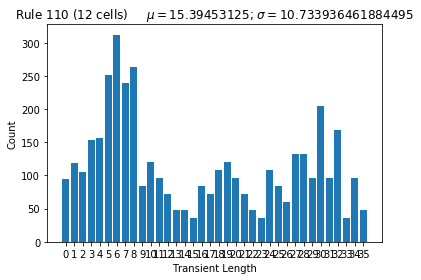

In [6]:
# find the distribution of transient lengths
transients = np.array(t_len)
val, count = np.unique(transients, return_counts=True)

t_mean = np.mean(transients)
t_std = np.std(transients)

fig, ax = plt.subplots()
ax.bar(val, count)
ax.set_xticks(np.arange(0, transients.max() + 1))
ax.set_xlabel('Transient Length')
ax.set_ylabel('Count')
ax.set_title('Rule {0} ({1} cells)'.format(rule, cells) + '\t' + r'$\mu={0}$; $\sigma={1}$'.format(t_mean, t_std))
plt.show()

So there are all of the dynamics we were looking for in a singlt STG. The next step is to see how these values change as the number of cells is increased. Now we can extend this to the dependence of these things as a function of the number of cells in our ECA. First we'll wrap everything we've done so far into some functions

## Dynamics of ECA as a function of the number of cells

In [11]:
def period_stats(G):
    """ Returns number of attractors, as well as the mean and standard deviation of their periods """
    cycles = nx.simple_cycles(G)

    cycle_lens = []
    for i, c in enumerate(cycles):
        cycle_lens.append(len(c))
    
    # stats
    n_cycles = i + 1
    p_mean = np.array(cycle_lens).max()
    p_std = np.array(cycle_lens).std()

    return (n_cycles, p_mean, p_std)

def transient_stats(G):
    """ Returns the mean and standard deviation of transient length """
    # this list will track all of the transient lengths
    t_len = []

    cycles = nx.simple_cycles(STG)
    # need to do this for each attractor
    for cycle in cycles:
        # set to ignore 
        cyc_nodes = set(cycle)
        for node in cycle:
            # initialize the queue and our distance counter
            queue = [node]
            level = {node: 0}
            # keep going til the queue is done
            while queue:
                # remove the first element, thats what we check next
                base = queue.pop(0)
                for pred in [p for p in STG.predecessors(base) if p not in cyc_nodes]:
                    queue.append(pred)
                    # we know that this must be one step farther out than the checked node
                    level[pred] = level[base] + 1
            t_len.extend([l for l in level.values()])

    # stats
    t_mean = np.array(t_len).mean()
    t_std = np.array(t_len).std()

    return (t_mean, t_std)

Now we'll iterate over various sizes of ECA and calculate our dynamic properties on the STGs for each size.

In [12]:
# which rule do we want to look at
rule = 30
cells = np.arange(3, 17)

# make some lists for all of our measurements
n_atrs = []
p_means = []
p_stds = []
t_means = []
t_stds = []
for n_cell in cells:
    STG = nx.read_graphml('../data/eca_stgs/' + str(rule) + '/' + str(n_cell) + '_cells.graphml')

    # attractor features
    n_atr, p_mean, p_std = period_stats(STG)
    n_atrs.append(n_atr)
    p_means.append(p_mean)
    p_stds.append(p_std)

    # transient features
    t_mean, t_std = transient_stats(STG)
    t_means.append(t_mean)
    t_stds.append(t_std)

n_atrs = np.array(n_atrs)
p_means = np.array(p_means)
p_stds = np.array(p_stds)
t_means = np.array(t_means)
t_stds = np.array(t_stds)


## Number of Attractors
Now we can take a look at the number of attractors as the number of cells increases.

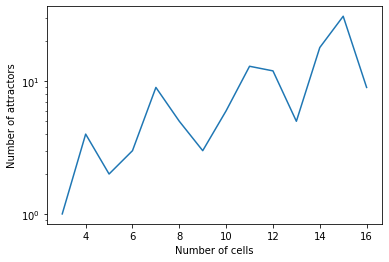

In [13]:
fig, ax = plt.subplots()
ax.plot(cells, n_atrs)
ax.set_xlabel('Number of cells')
ax.set_ylabel('Number of attractors')
ax.set_yscale('log')
plt.show()

## Period of attractors
Mean and standard deviation ofattractor periods

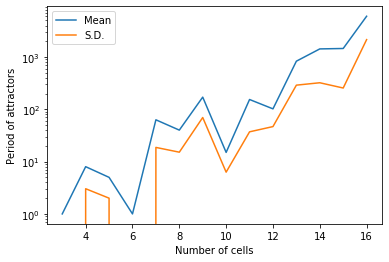

In [14]:
fig, ax = plt.subplots()
ax.plot(cells, p_means, label='Mean')
ax.plot(cells, p_stds, label='S.D.')
# ax.fill_between(cells, p_means + p_std, p_means - p_std, alpha=0.5, color='C1')
ax.set_xlabel('Number of cells')
ax.set_ylabel('Period of attractors')
ax.set_yscale('log')
ax.legend()
plt.show()

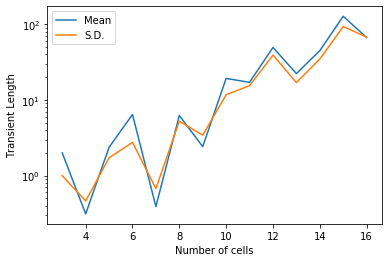

In [15]:
fig, ax = plt.subplots()
ax.plot(cells, t_means, label='Mean')
ax.plot(cells, t_stds, label='S.D.')
# ax.fill_between(cells, p_means + p_std, p_means - p_std, alpha=0.5, color='C1')
ax.set_xlabel('Number of cells')
ax.set_ylabel('Transient Length')
ax.set_yscale('log')
ax.legend()
plt.show()